# Group 4, TT4L


1201202935 Jocelyn Pua 

1201203287 Wong Wan Kei 

1211307746 Lim Sir Yuean 

1201103290 Lim Jun Jie 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from matplotlib import cm

## <font color='Green'>Data Overview</font>

<font size = 5 color='lightyellow'>The dataset's initial values, dimensions, and column data types are reviewed to understand its structure and how to handle each column.</font>

In [2]:
df = pd.read_excel("Sample - Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
print("Data types of features:\n",df.dtypes)
shape = df.shape
print("\nrows:",shape[0],"columns:",shape[1])


Data types of features:
 Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

rows: 9994 columns: 21


## <font color='Green'>Data Cleaning</font>

<font size = 5 color='lightyellow'>Duplicate rows are removed to ensure data integrity.</font>

In [4]:
# find duplicated rows
print("Total number of duplicate rows:",df.duplicated(keep=False).sum())

Total number of duplicate rows: 0


No duplicate rows found.

## <font color='Green'>Data Preprocessing</font>

<font size = 5 color='lightyellow'>Irrelevant columns are removed from the dataset since their values are unnecessary.</font>

In [5]:
print("Before removal of columns:")
print(df.columns)

df.drop(['Row ID', 'Country', 'Customer Name', 'Product Name', 
         'Order ID', 'Postal Code', 'Product ID', 'Ship Date'], axis=1, inplace=True)

print("\nAfter removal of columns:")
print(df.columns)

Before removal of columns:
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

After removal of columns:
Index(['Order Date', 'Ship Mode', 'Customer ID', 'Segment', 'City', 'State',
       'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount',
       'Profit'],
      dtype='object')


<font size = 5 color='lightyellow'>Find and fill null values</font>

In [6]:
df.isnull().sum()

Order Date      0
Ship Mode       0
Customer ID     0
Segment         0
City            0
State           0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

The output confirms that no rows contain null values, so there is no need to fill in any missing data.

In [7]:
# convert to date time format
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [8]:
# get year, date, month, quarter, and day f order
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Quarter'] = df['Order Date'].dt.quarter

# value mapping
day_of_week_names = {
    0: 'Saturday',
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday'
}

df['Order Day of Week'] = df['Order Date'].dt.day_of_week.apply(lambda x: day_of_week_names[x])

## <font color='lightpink'><u>Sub-question 1: </u> Which customer segments from which region should be targeted to increase sales?    </font>

## <font size = 5 color='yellow'><u>Exploratory Data Analysis (EDA) </u></font>

<font size = 5>Categorizing Customer Segments based on Purchasing Power</font>

In [9]:
# define rank for each ship mode
ship_mode_rank = {
    'Same Day': 4,
    'First Class': 3,
    'Second Class': 2,
    'Standard Class': 1
}

#df_copy = df.copy()
df['Encoded Ship Mode'] = df['Ship Mode'].map(ship_mode_rank)


Standardize data for categorizing customer segments

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Group by Customer ID and aggregate sales-related metrics
customer_data = df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean',
    'Profit': 'sum',
    'Encoded Ship Mode':  lambda x: x.mode().iloc[0]
}).reset_index()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('Customer ID', axis=1))

Get optimal number of clusters customer segments

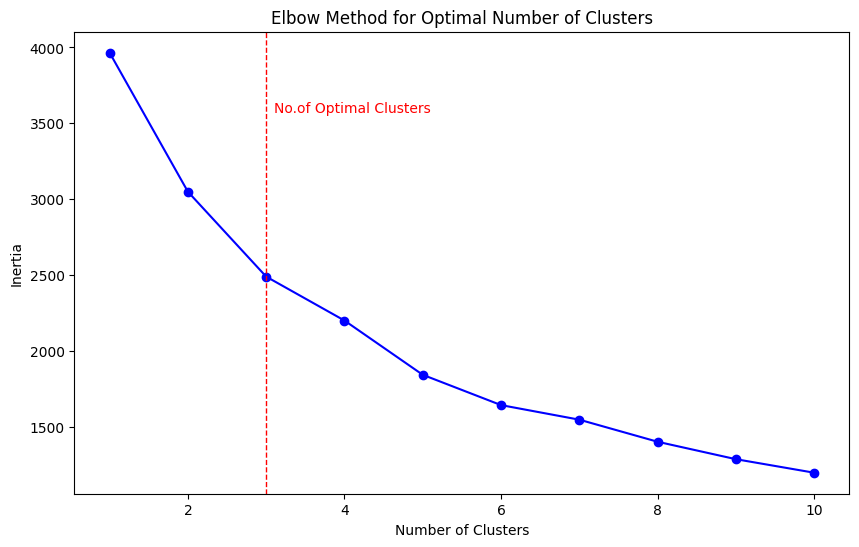

In [11]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')


optimal_clusters = 3 
# mark elbow point
plt.axvline(x=optimal_clusters, color='red', linestyle='--', linewidth=1)
plt.text(optimal_clusters + 0.1, max(inertia) * 0.9, 'No.of Optimal Clusters', color='red', fontsize=10)

plt.show()

Fit optimal cluster to K-Means model

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

KMeans(n_clusters=3, random_state=42)

Add cluster labels to the customer data

In [13]:
customer_data['Cluster'] = kmeans.labels_

# merge cluster labels to original dataframe
df_k = pd.merge(df, customer_data[['Customer ID', 'Cluster']], on='Customer ID', how='left')

Perform Distribution Analysis on sales, quantity, discount, and profit

In [14]:
sales = go.Box(x=df_k['Sales'],name='Sales')
Quantity = go.Box(x=df_k['Quantity'],name='Quantity')
Discount = go.Box(x=df_k['Discount'],name='Discount')
Profit = go.Box(x=df_k['Profit'],name='Profit')

fig = make_subplots(rows=2, cols=2)
fig.append_trace(sales, row = 1, col = 1)
fig.append_trace(Quantity, row = 1, col = 2)
fig.append_trace(Discount, row = 2, col = 1)
fig.append_trace(Profit, row = 2, col = 2)

fig.update_layout(
    title_text = 'Distribution of the numerical data (With Outliers)',
    title_font_size = 24,
    title_x=0.45)

fig.show()

Remove outliers using boxplot method

In [15]:
def remove_outliers(df, columns):
    # Calculate the interquartile range (IQR) for each specified column
    Q1 = df[columns].quantile(0.10)
    Q3 = df[columns].quantile(0.90)
    IQR = Q3 - Q1
    
    # Define the upper and lower bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers from each specified column
    for col in columns:
        df = df[(df[col] >= lower_bound[col]) & (df[col] <= upper_bound[col])]
    
    return df

# Define columns to consider for outlier removal
columns_to_remove_outliers = ['Sales', 'Quantity', 'Discount', 'Profit']

# Apply the remove_outliers function to df and customer_data
df_cleaned = remove_outliers(df_k, columns_to_remove_outliers)
customer_data = remove_outliers(customer_data, columns_to_remove_outliers)

In [16]:
sales = go.Box(x=df_cleaned ['Sales'],name='Sales')
Quantity = go.Box(x=df_cleaned ['Quantity'],name='Quantity')
Discount = go.Box(x=df_cleaned ['Discount'],name='Discount')
Profit = go.Box(x=df_cleaned ['Profit'],name='Profit')

fig = make_subplots(rows=2, cols=2)
fig.append_trace(sales, row = 1, col = 1)
fig.append_trace(Quantity, row = 1, col = 2)
fig.append_trace(Discount, row = 2, col = 1)
fig.append_trace(Profit, row = 2, col = 2)

fig.update_layout(
    title_text = 'Distribution of the numerical data (Reduced Outliers)',
    title_font_size = 24,
    title_x=0.45)

fig.show()

Categorize Customer based on Purchasing Power using Fitted K-Means 

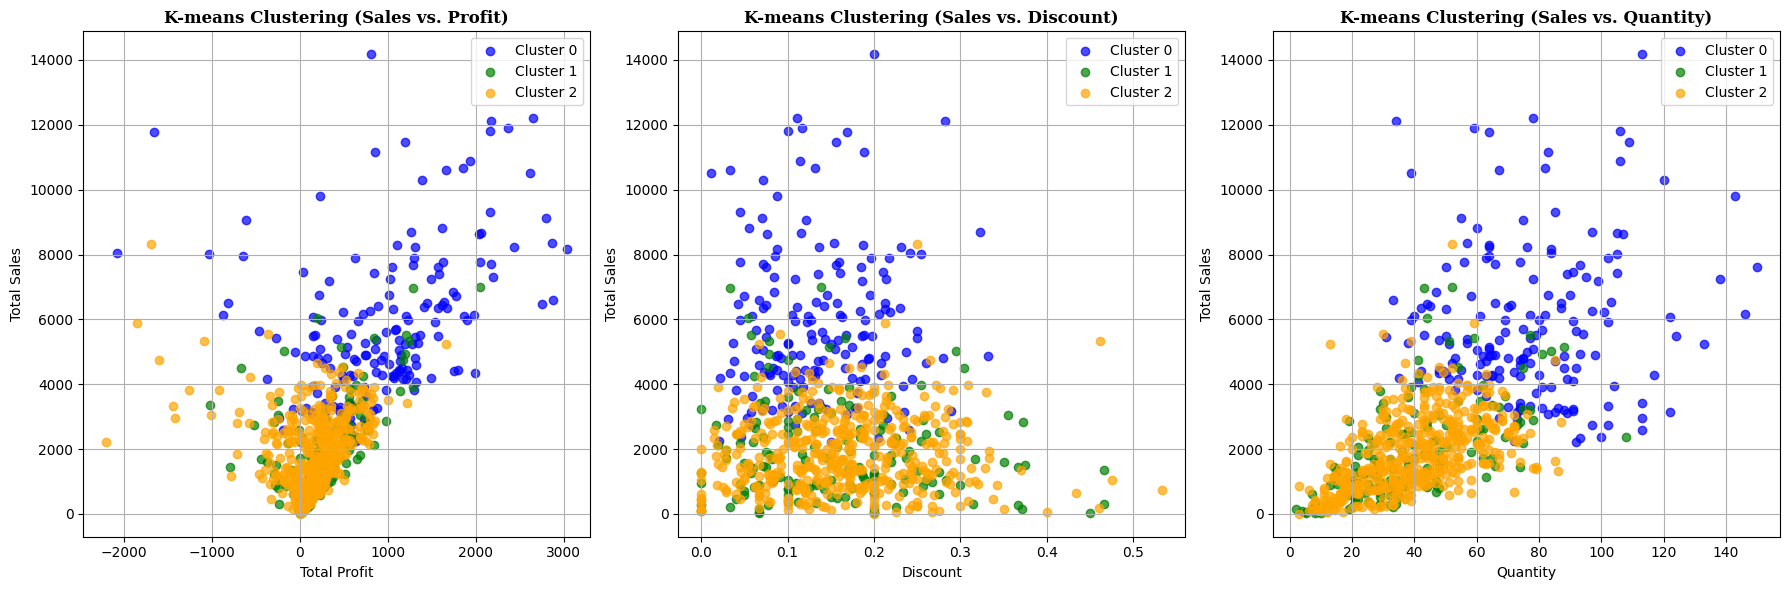

In [17]:
# Plotting the clusters
plt.figure(figsize=(18, 6)) 
colors = ['blue', 'green', 'orange'] 

# Sales vs Profit plot
plt.subplot(1, 3, 1)
for cluster in range(customer_data['Cluster'].nunique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Profit'], cluster_data['Sales'], label=f'Cluster {cluster}', color=colors[cluster], alpha=0.7)

plt.xlabel('Total Profit')
plt.ylabel('Total Sales')
plt.title('K-means Clustering (Sales vs. Profit)', fontweight='bold', fontfamily='serif')
plt.legend()
plt.grid(True)  

# Sales vs Discount plot
plt.subplot(1, 3, 2)
for cluster in range(customer_data['Cluster'].nunique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Discount'], cluster_data['Sales'], label=f'Cluster {cluster}', color=colors[cluster], alpha=0.7)

plt.xlabel('Discount')
plt.ylabel('Total Sales')
plt.title('K-means Clustering (Sales vs. Discount)',fontweight='bold', fontfamily='serif')
plt.legend()
plt.grid(True)  

# Sales vs Quantity plot
plt.subplot(1, 3, 3)
for cluster in range(customer_data['Cluster'].nunique()):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Quantity'], cluster_data['Sales'], label=f'Cluster {cluster}', color=colors[cluster], alpha=0.7)

plt.xlabel('Quantity')
plt.ylabel('Total Sales')
plt.title('K-means Clustering (Sales vs. Quantity)', fontweight='bold', fontfamily='serif')
plt.legend()
plt.grid(True)  

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

In [18]:
# 3D scatter plot with all comparisons combined
fig = go.Figure(data=[go.Scatter3d(
    x=customer_data['Sales'],
    y=customer_data['Quantity'],
    z=customer_data['Discount'],
    mode='markers',
    marker=dict(
        size=8,
        color=customer_data['Cluster'],  
        colorscale='Viridis',  # color scale
        opacity=0.8
    )
)])

# Set layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Total Sales'),
        yaxis=dict(title='Quantity'),
        zaxis=dict(title='Discount'),
    ),
    title='Customer Segmentation by K-means Clustering (Sales, Quantity, and Discount)',
    margin=dict(l=0, r=0, b=0, t=30)  # Adjust margin to prevent overlap with title
)

# Show plot
fig.show()

Determine Top 3 cities with Customer Segments of High Purchasing Power 

Index(['Customer ID', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Encoded Ship Mode', 'Cluster'],
      dtype='object')


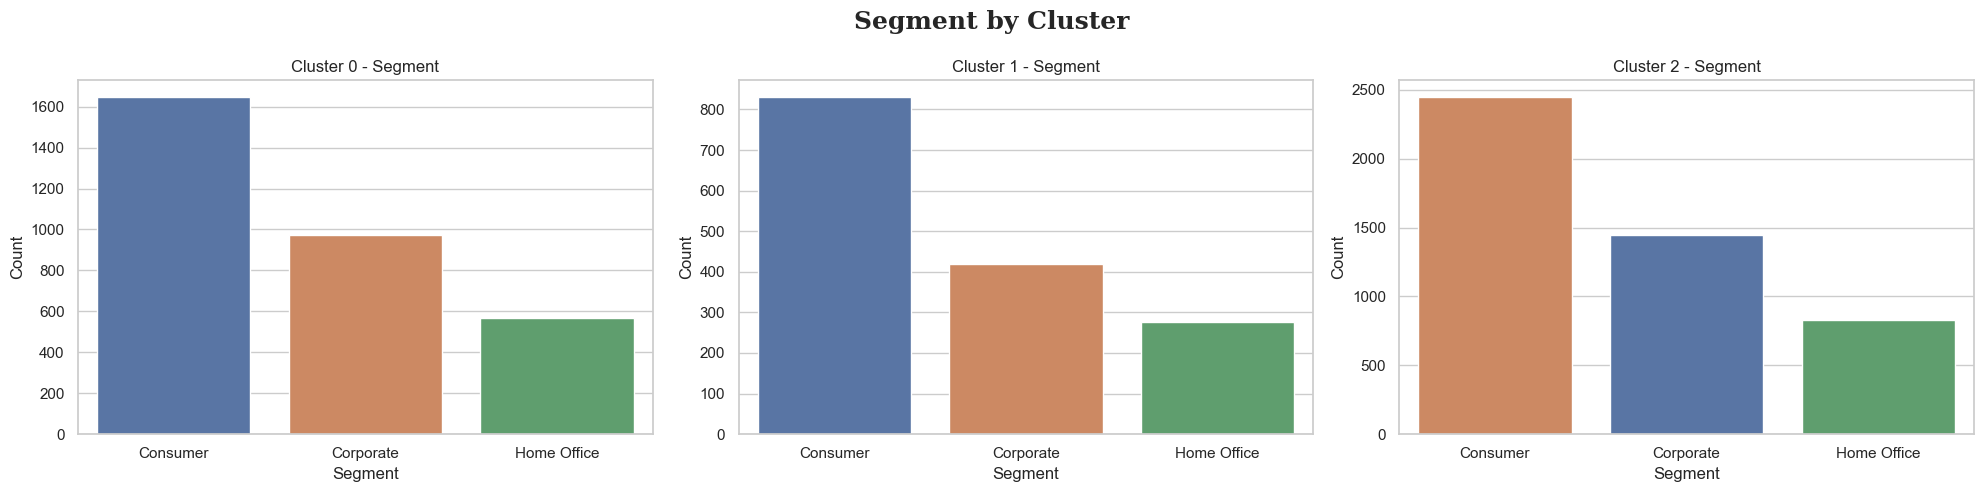

In [19]:
print(customer_data.columns)
cluster_segment_order = {}
for i in range(3):
    cluster_segment_order[i] =  df_cleaned[ df_cleaned['Cluster'] == i]['Segment'].value_counts().index

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a plot
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.countplot(x='Segment', data= df_cleaned[df_cleaned['Cluster'] == i], order=cluster_segment_order[i], hue='Segment', legend=False)
    plt.title(f'Cluster {i} - Segment')
    plt.xlabel('Segment')
    plt.ylabel('Count')

plt.suptitle('Segment by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

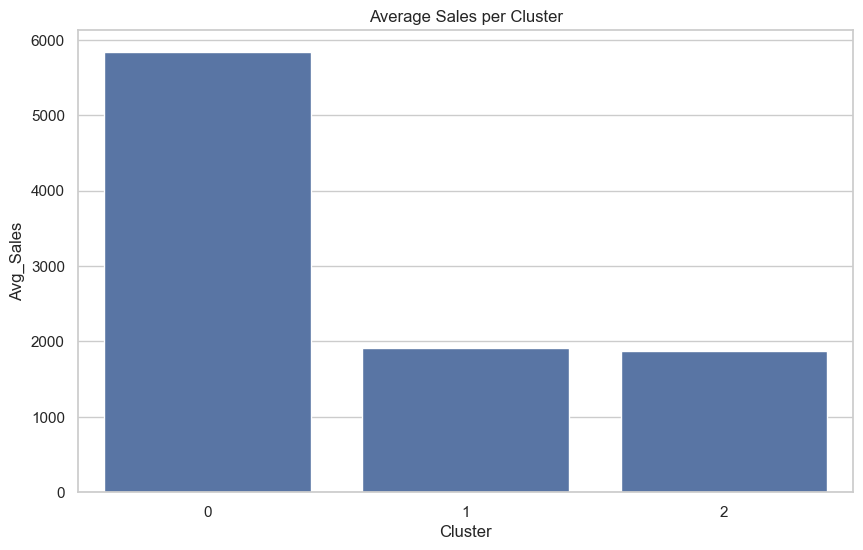

   Cluster    Avg_Sales  Total_Sales  Avg_Quantity  Avg_Profit
0        0  5837.039316  998133.7231     77.204678  937.686707
1        1  1920.241650  293796.9724     38.516340  250.217639
2        2  1880.353808  855560.9828     39.767033  151.249471


In [20]:
# Analyze the average sales per cluster
cluster_summary = customer_data.groupby('Cluster').agg({
    'Sales': ['mean', 'sum'],
    'Quantity': 'mean',
    'Profit': 'mean'
}).reset_index()

cluster_summary.columns = ['Cluster', 'Avg_Sales', 'Total_Sales', 'Avg_Quantity', 'Avg_Profit']

# Plot the average sales per cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_summary, x='Cluster', y='Avg_Sales')
plt.title('Average Sales per Cluster')
plt.show()

print(cluster_summary)

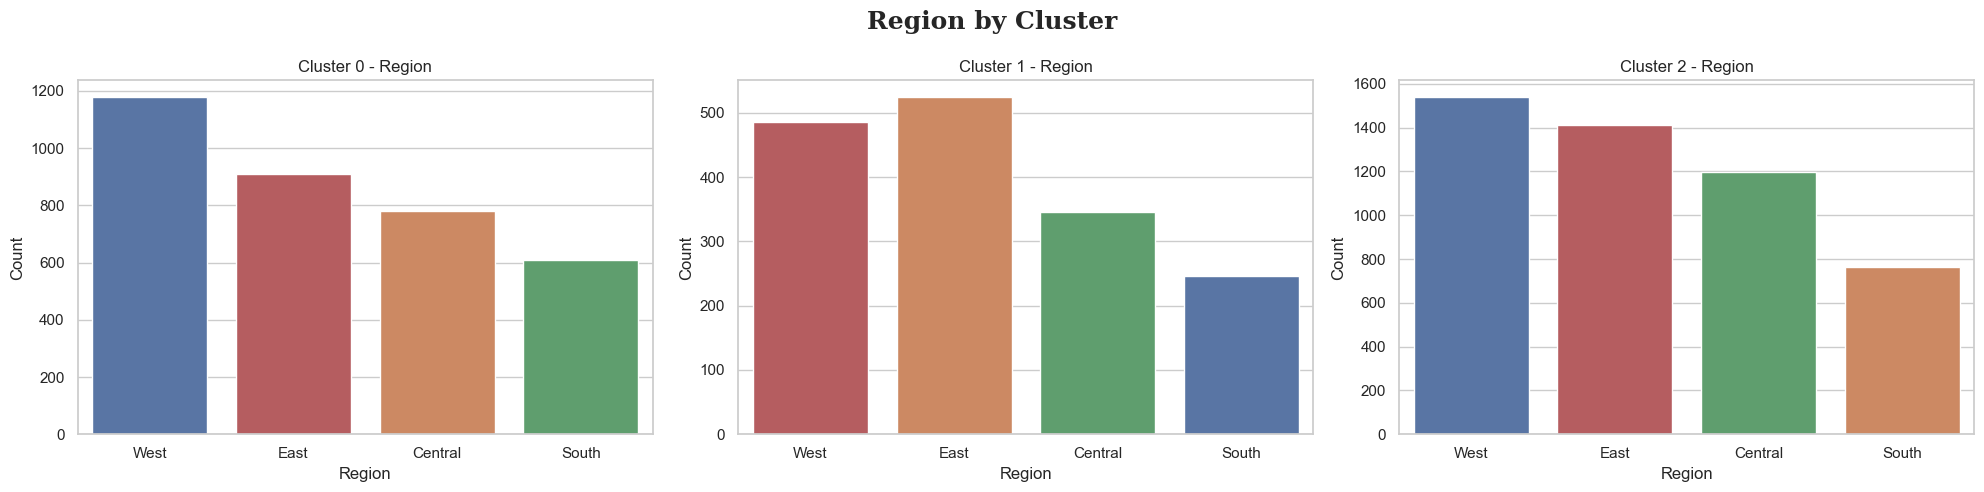

In [21]:
region_order = df_k[df_k['Cluster'] == i]['Region'].value_counts().index

# Set the style
sns.set(style="whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Loop through each cluster and create a plot
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.countplot(x='Region', data=df_k[df_k['Cluster'] == i], order=region_order, hue='Region',legend=False)
    plt.title(f'Cluster {i} - Region')
    plt.xlabel('Region')
    plt.ylabel('Count')

plt.suptitle('Region by Cluster', fontsize=18, fontweight='bold', fontfamily='serif')
plt.tight_layout()
plt.show()

<b><u>Gathered Insights</b></u>

According to K-means algorithm, the most populated customer regions is the West.

<u>Cluster 0: Regular Shoppers</u>

- Order frequency: high count of orders, but not the highest, indicate regualar behaviour
- Segment composition: Primarily consist of consumers
- Sales and Profit: Moderate sales and profit values, with a focus on small to medium-sized orders
- Most populated region: West

<u>Cluster 1: Premium Shoppers</u>

- Order frequency: moderate count of order, lower than cluster 0 and cluster 2
- Segment composition: Predominantly corporate due to large portion of consumers in cluster 0
- Sales and Profit: Higher sales and profit compared to other clusters, indicating higher value purchases.
- Most populated region: East

<u>Cluster 3: Bulk buyers (retailers or business owners)</u>

- Order frequency: moderate count of order, but purchase a lot more quantities
- Segment composition: mix of consumers, corporate and bulk buyers due to consistent evenly counts
- Sales and Profit: Higher sales and profit compared to other clusters, indicating higher value purchases
- Most populated region: West

## <font size = 5 color='yellow'><u>Data Modelling </u></font>

In [22]:
features = df_k[['Sales', 'Profit', 'Quantity']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

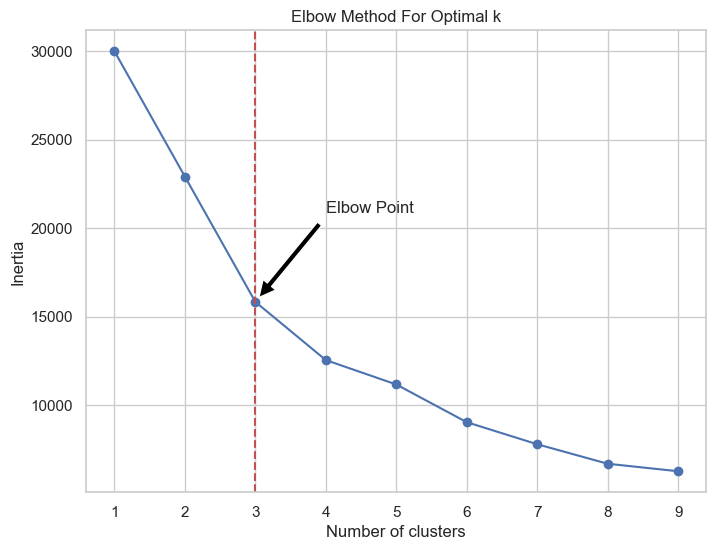

In [23]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

optimal_k = 3
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.annotate('Elbow Point', xy=(optimal_k, inertia[optimal_k-1]), 
             xytext=(optimal_k+1, inertia[optimal_k-1]+5000),
             arrowprops=dict(facecolor='black', shrink=0.05))


plt.show()

In [24]:
kmeans = KMeans(n_clusters=3, random_state=42)

df_k['Cluster'] = kmeans.fit_predict(scaled_features)

df_k['Cluster'] = kmeans.labels_

In [25]:
# Aggregate data by city and cluster
region_cluster_counts = df_k.groupby(['Region', 'Cluster']).size().unstack(fill_value=0)
segment_cluster_counts = df_k.groupby(['Segment', 'Cluster']).size().unstack(fill_value=0)

# Assume cluster 2 is the high-value cluster based on your analysis
for i in range(0,3):
    target_cluster = i

    # Sort cities based on the count of cluster customers
    target_segments = segment_cluster_counts.sort_values(by=target_cluster, ascending=False)[target_cluster]
    target_region = region_cluster_counts.sort_values(by=target_cluster, ascending=False)[target_cluster]
    print("Cluster:",i,"\n",target_segments,"\n",target_region,"\n")

# Calculate mean values for each cluster
cluster_summary = df_k.groupby('Cluster')[['Sales', 'Profit', 'Quantity']].sum()
print(cluster_summary)

# Calculate count of customers per cluster
cluster_counts = df_k['Cluster'].value_counts()
print(cluster_counts)

Cluster: 0 
 Segment
Consumer       4042
Corporate      2294
Home Office    1375
Name: 0, dtype: int64 
 Region
West       2455
East       2201
Central    1800
South      1255
Name: 0, dtype: int64 

Cluster: 1 
 Segment
Consumer       13
Home Office     8
Corporate       6
Name: 1, dtype: int64 
 Region
East       14
Central     6
West        4
South       3
Name: 1, dtype: int64 

Cluster: 2 
 Segment
Consumer       1136
Corporate       720
Home Office     400
Name: 2, dtype: int64 
 Region
West       744
East       633
Central    517
South      362
Name: 2, dtype: int64 

                Sales       Profit  Quantity
Cluster                                     
0        9.569834e+05   82188.4063     21844
1        2.074998e+05   70475.9423       140
2        1.132718e+06  133732.6731     15889
Cluster
0    7711
2    2256
1      27
Name: count, dtype: int64


## <font size = 5 color='yellow'><u> Model Validation</u></font>

<b><u>Silhoutte Score: </b></u>

- Ranging from -1 -to 1 whereby +1 is well clustered, 0 is very close to neighbouring clusters, and -1 is wrongly clustered.

<b><u>Davies-Bouldin Index: </b></u>

- Measures the average similarity ratio of each cluster with respect to others. It is based on average distance between clusters and spread within clusters ranging from 0 to 1. A good sign of effective clustering is being compact and distinct.

In [26]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate Silhouette Score
sil_score = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {sil_score}')

# Calculate Davies-Bouldin Index
db_score = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_score}')

Silhouette Score: 0.5494948635956662
Davies-Bouldin Index: 0.8383991980272144


1. Our Silhouette Score is about 0.55, indicating a moderately good clustering

2. Our Davies-Bouldin Score is about 0.84, indicating that the clusters are compact and distinct.

## <font color='Red'><u>Sub-question 2: </u> Will item categories increase sales when discounted? </font>

## <font size = 5 color='yellow'><u>Exploratory Data Analysis (EDA) </u></font>

<font size = 5>Find Sale Performance for Item Categories</font>

In [27]:
total_sales_by_category = df.groupby('Category')['Sales'].sum()

print(total_sales_by_category)

Category
Furniture          741999.7953
Office Supplies    719047.0320
Technology         836154.0330
Name: Sales, dtype: float64


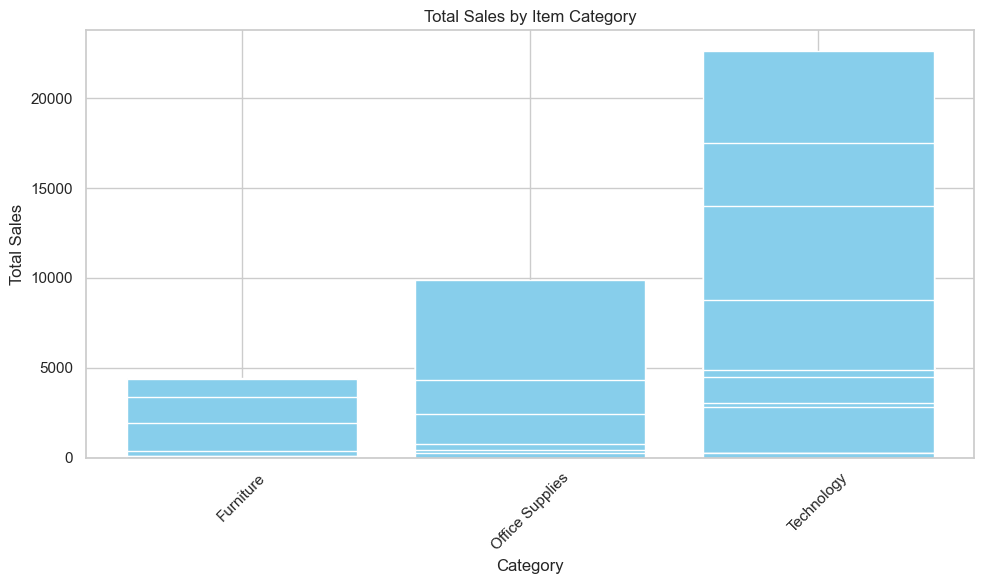

In [28]:
# plot Sales by item
plt.figure(figsize=(10, 6))
plt.bar(df['Category'], df['Sales'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Item Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

<font size = 5>Find Quantity Sold for Item Categories</font>

In [29]:
# Extract category and quant col
category_quantity_df = df[['Category','Quantity']]

# Aggregate the data by category 
category_quantity_agg = category_quantity_df.groupby('Category').sum().reset_index()

#Display the dataframe
print(category_quantity_agg)

          Category  Quantity
0        Furniture      8028
1  Office Supplies     22906
2       Technology      6939


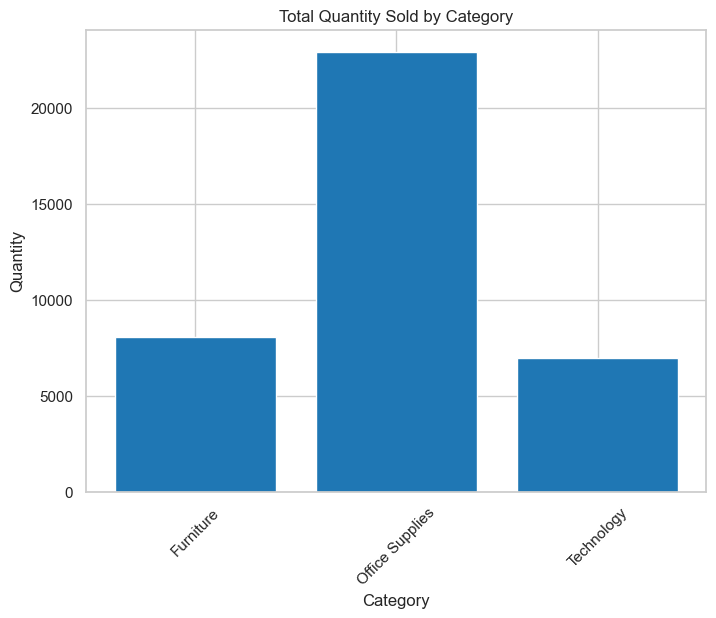

In [30]:
plt.figure(figsize=(8, 6))
plt.bar(category_quantity_agg['Category'], category_quantity_agg['Quantity'], color='tab:blue')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.title('Total Quantity Sold by Category')
plt.xticks(rotation=45)
plt.show()

<font size = 5>Find Discount Patterns for Item Categories</font>

In [31]:
# Extract Category, Quantity, and Discount columns
category_quantity_discount_df = df[['Category', 'Quantity', 'Discount']]

print(category_quantity_discount_df)

             Category  Quantity  Discount
0           Furniture         2      0.00
1           Furniture         3      0.00
2     Office Supplies         2      0.00
3           Furniture         5      0.45
4     Office Supplies         2      0.20
...               ...       ...       ...
9989        Furniture         3      0.20
9990        Furniture         2      0.00
9991       Technology         2      0.20
9992  Office Supplies         4      0.00
9993  Office Supplies         2      0.00

[9994 rows x 3 columns]


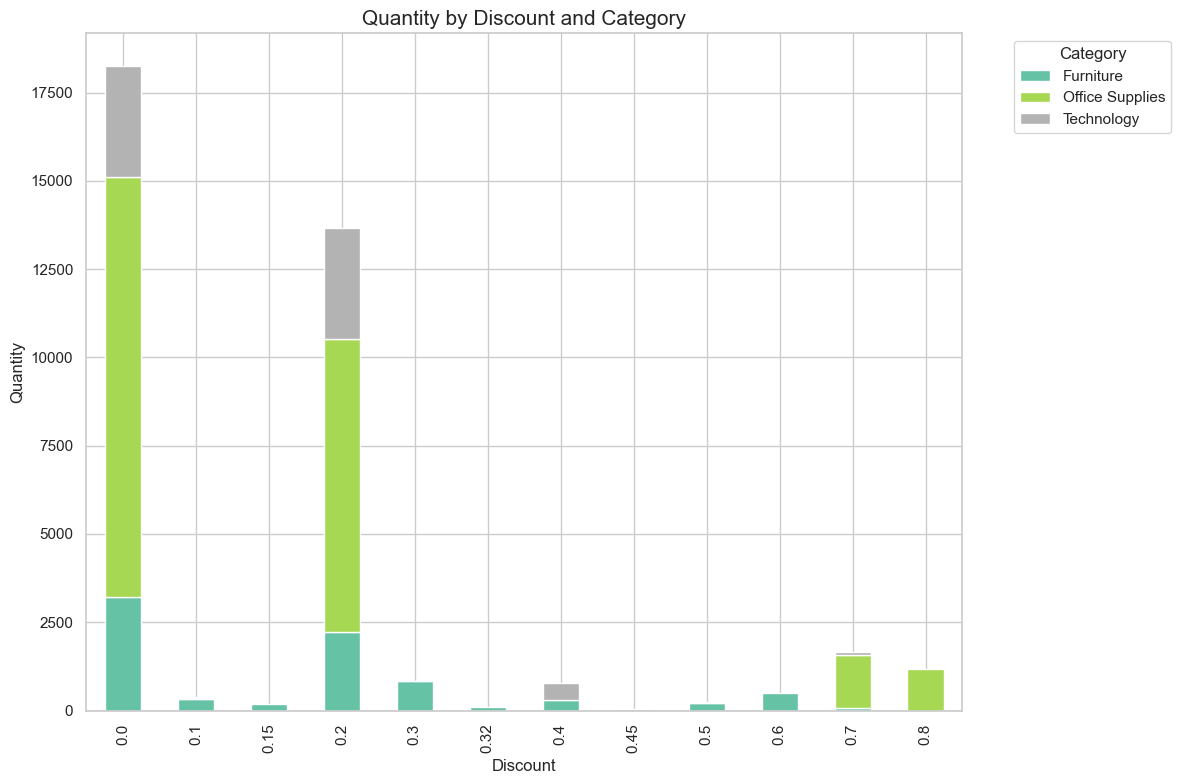

In [32]:
agg_df = category_quantity_discount_df.pivot_table(index='Discount', columns='Category', values='Quantity', aggfunc='sum').fillna(0)

# Plot the stacked bar chart
agg_df.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='Set2')

# Add labels and title
plt.xlabel('Discount', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Quantity by Discount and Category', fontsize=15)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [33]:
# Create new column to indicate if discount was applied
df['Discounted'] = df['Discount'] > 0

# Extract relevant columns
category_discount_df = df [['Category', 'Quantity', 'Discounted']]

# Aggregate the data by category and discount status
category_discount_agg = category_discount_df.groupby(['Category', 'Discounted',]).sum().reset_index()

#Display the aggregated dataframe
print(category_discount_agg)

          Category  Discounted  Quantity
0        Furniture       False      3224
1        Furniture        True      4804
2  Office Supplies       False     11886
3  Office Supplies        True     11020
4       Technology       False      3157
5       Technology        True      3782


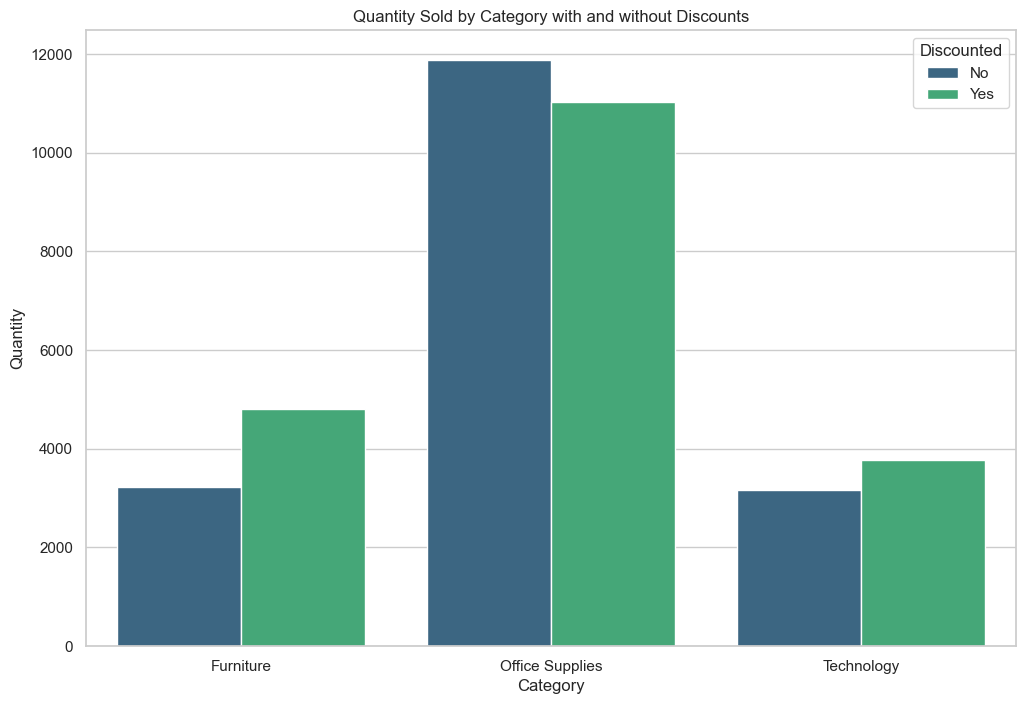

In [34]:
# Plot the bar chart
plt.figure(figsize=(12,8))
ax = sns.barplot(data=category_discount_agg, x='Category', y='Quantity', hue='Discounted', palette = 'viridis')
plt.xlabel('Category')
plt.ylabel('Quantity')
plt.title('Quantity Sold by Category with and without Discounts')

# Automatically handle the legend
handles, lables = ax.get_legend_handles_labels()
ax.legend(handles,['No','Yes'], title='Discounted')

plt.show()

<b><u>Gathered Insights</b></u>

Although technology item category has the highest sales performance, the highest quantity sold belongs to the office supplies category. 

When discounts are applied, the office supplies category gets the most discount treatment. 

For other categories, furniture shows a significant increase in sales when discounted, suggesting that customers are likely to purchase more furniture items when they perceive they are getting a good deal. This indicates a high price sensitivity in this category, where discounts can effectively boost sales.

Interestingly, office supplies show a slight decrease in sales when discounted. 

## <font size = 5 color='yellow'><u>Feature Engineering </u></font>

<font size = 5>Normalize Sales, Quantity, Discount, and Profit</font>

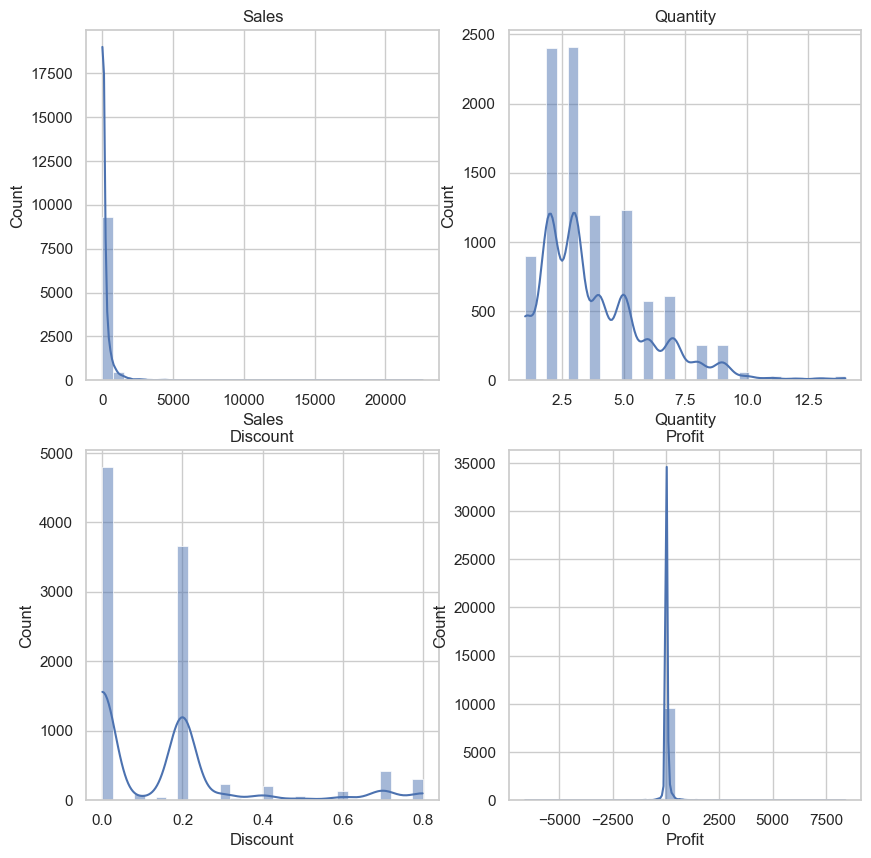

In [35]:
# before normalizing
plt.subplot(221)
sns.histplot(df, x="Sales", bins=30,kde=True)
plt.title('Sales')

plt.subplot(222)
sns.histplot(df, x="Quantity", bins=30,kde=True)
plt.title('Quantity')

plt.subplot(223)
sns.histplot(df, x="Discount", bins=30,kde=True)
plt.title('Discount')

plt.subplot(224)
sns.histplot(df, x="Profit", bins=30,kde=True)
plt.title('Profit')

fig = plt.gcf()
fig.set_size_inches(10,10)

c:\Program Files\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log1p



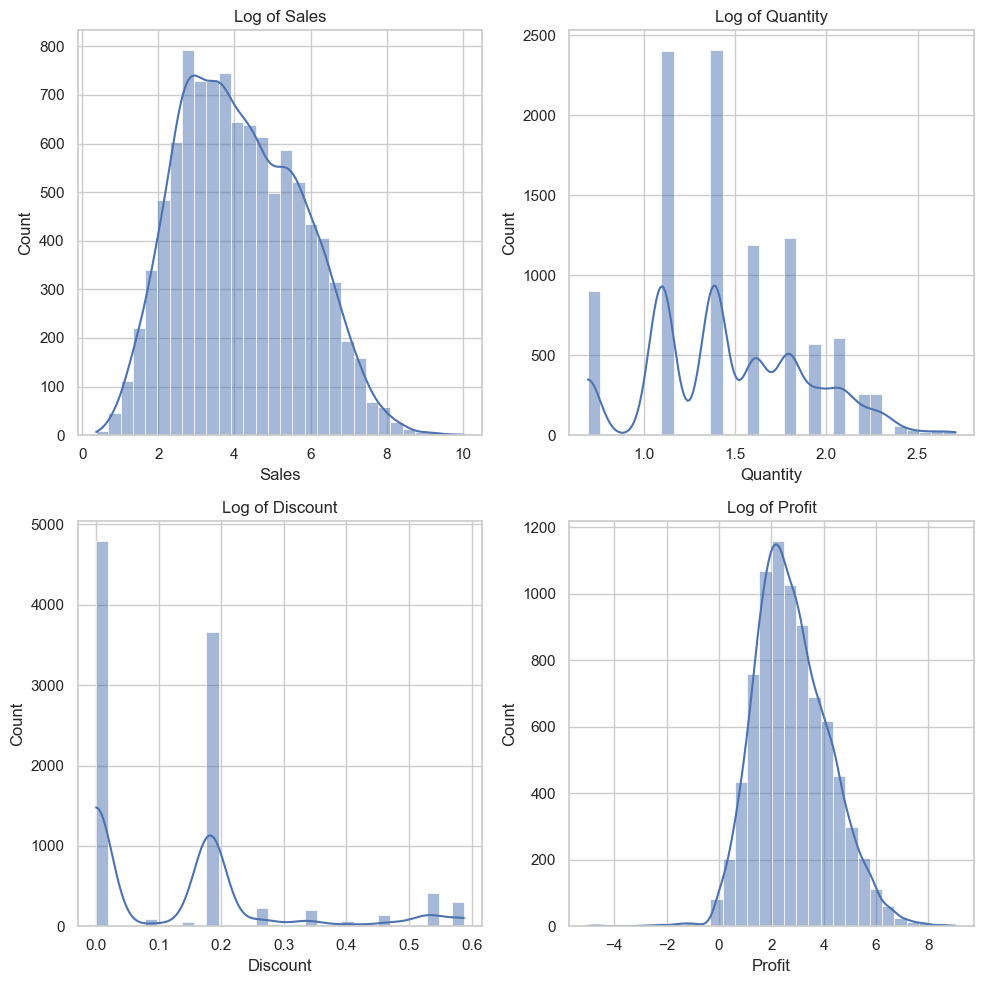

In [36]:
# After Normalizing into a new dataframe
df_k['Sales'] = np.log1p(df['Sales'])
df_k['Quantity'] = np.log1p(df['Quantity'])
df_k['Discount'] = np.log1p(df['Discount'])
df_k['Profit'] = np.log1p(df['Profit'])

plt.subplot(221)
sns.histplot(df_k, x="Sales", bins=30, kde=True)
plt.title('Log of Sales')

plt.subplot(222)
sns.histplot(df_k, x="Quantity", bins=30, kde=True)
plt.title('Log of Quantity')

plt.subplot(223)
sns.histplot(df_k, x="Discount", bins=30, kde=True)
plt.title('Log of Discount')

plt.subplot(224)
sns.histplot(df_k, x="Profit", bins=30, kde=True)
plt.title('Log of Profit')

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.tight_layout() 
plt.show()

In [37]:
# Encode the ship mode
ship_mode_rank = {
    'Same Day': 4,
    'First Class': 3,
    'Second Class': 2,
    'Standard Class': 1
}
df['Encoded Ship Mode'] = df['Ship Mode'].map(ship_mode_rank)

## <font size = 5 color='yellow'><u>Data Modelling </u></font>

In [38]:
# if sales more than 75% of increase
sales_threshold = np.percentile(df['Sales'], 75)
df['Sales Increase'] = (df['Sales'] > sales_threshold).astype(int)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



features = ['Discount', 'Quantity', 'Encoded Ship Mode', 'Year', 'Month', 'Day', 'Category']
target = 'Sales Increase'

# encoding like this will alter the original, not recommended
# df_train = pd.get_dummies(df, columns=['Category'], drop_first=True)

# Define X and y
X = df[features]
y = df[target]

categorical_columns = ['Category']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=False)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1512
           1       0.68      0.09      0.15       487

    accuracy                           0.77      1999
   macro avg       0.72      0.54      0.51      1999
weighted avg       0.75      0.77      0.69      1999

[[1492   20]
 [ 445   42]]


C:\Users\limsi\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



## <font size = 5 color='yellow'><u> Model Validation</u></font>

<font size = 5>K-Fold Cross Validation</font>

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

In [41]:
# Calculate mean and standard deviation
mean_score = scores.mean()
std_dev_score = scores.std()

# standard of k-fold is 4, meaning 4 different groups from 1 dataframe
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {mean_score:.4f}")
print(f"Standard Deviation: {std_dev_score:.4f}")

Cross-Validation Scores: [0.77088544 0.76638319 0.77938969 0.76688344 0.77027027]
Mean Accuracy: 0.7708
Standard Deviation: 0.0047


<b><u>Mean: </b></u>
- Overall model's performance. A good range is between 70 to 90.

<b><u>Standard Deviation: </b></u>
- Overall model's consistency accross different k-folds (number of groups in a data sample. Standard is 4-folds). A good range is under 1, the lower the SD, the more stable the performance.

To summarize, the model has a mean accuracy of approximately 77.08% and standard deviation of approximately 0.0047. This means the model is fairly consistent when tested in different folds, indicating its prediction is accurate and stable. 

## <font color='cyan'><u>Sub-question 3: </u> Which item categories is the most profitable? </font>

## <font size = 5 color='yellow'><u>Exploratory Data Analysis (EDA) </u></font>

<font size = 5>Find which Item Category is Sold the most</font>

In [42]:
# Group by year, month, and segment, and sum the sales
monthly_category_sales = df.groupby(['Year', 'Month', 'Category'])['Sales'].sum().reset_index()
print(monthly_category_sales)

     Year  Month         Category       Sales
0    2014      1        Furniture   6242.5250
1    2014      1  Office Supplies   4851.0800
2    2014      1       Technology   3143.2900
3    2014      2        Furniture   1839.6580
4    2014      2  Office Supplies   1071.7240
..    ...    ...              ...         ...
139  2017     11  Office Supplies  31472.3370
140  2017     11       Technology  49918.7730
141  2017     12        Furniture  31407.4668
142  2017     12  Office Supplies  30436.9420
143  2017     12       Technology  21984.9100

[144 rows x 4 columns]


In [43]:
# Set the day of each date to 1 to represent the first day of the month
df['Month Start'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()

# Group by category, month start, and summing sales
monthly_category_sales = df.groupby(['Category', 'Month Start'])['Sales'].sum().reset_index()

# Count the number of days with orders in each month for each category
days_in_month = df.groupby(['Category', 'Month Start'])['Order Date'].nunique().reset_index()
days_in_month.rename(columns={'Order Date': 'Order_days'}, inplace=True)

# Merge the total monthly sales and days with orders
monthly_category_sales = pd.merge(monthly_category_sales, days_in_month, on=['Category', 'Month Start'])

# Calculate average daily sales per category
monthly_category_sales['Avg_daily_sales'] = monthly_category_sales['Sales'] / monthly_category_sales['Order_days']

# Iterate over each category and print the corresponding DataFrame
for category, data in monthly_category_sales.groupby('Category'):
    print(f"Category: {category}\n")
    print(data[['Month Start', 'Avg_daily_sales']])
    print("\n")

Category: Furniture

   Month Start  Avg_daily_sales
0   2014-01-01       480.194231
1   2014-02-01       367.931600
2   2014-03-01       857.291529
3   2014-04-01       567.488357
4   2014-05-01       432.049188
5   2014-06-01       695.059242
6   2014-07-01       601.169500
7   2014-08-01       457.521656
8   2014-09-01       992.353367
9   2014-10-01       769.015437
10  2014-11-01       980.221486
11  2014-12-01      1532.298325
12  2015-01-01       978.328467
13  2015-02-01       522.395667
14  2015-03-01       781.236437
15  2015-04-01       805.822962
16  2015-05-01       624.996700
17  2015-06-01       428.565500
18  2015-07-01       719.706316
19  2015-08-01       602.412012
20  2015-09-01      1382.790684
21  2015-10-01       632.980184
22  2015-11-01      1286.701354
23  2015-12-01      1049.355418
24  2016-01-01       508.182867
25  2016-02-01       356.868273
26  2016-03-01       609.575810
27  2016-04-01       695.373158
28  2016-05-01       687.265227
29  2016-06-01     

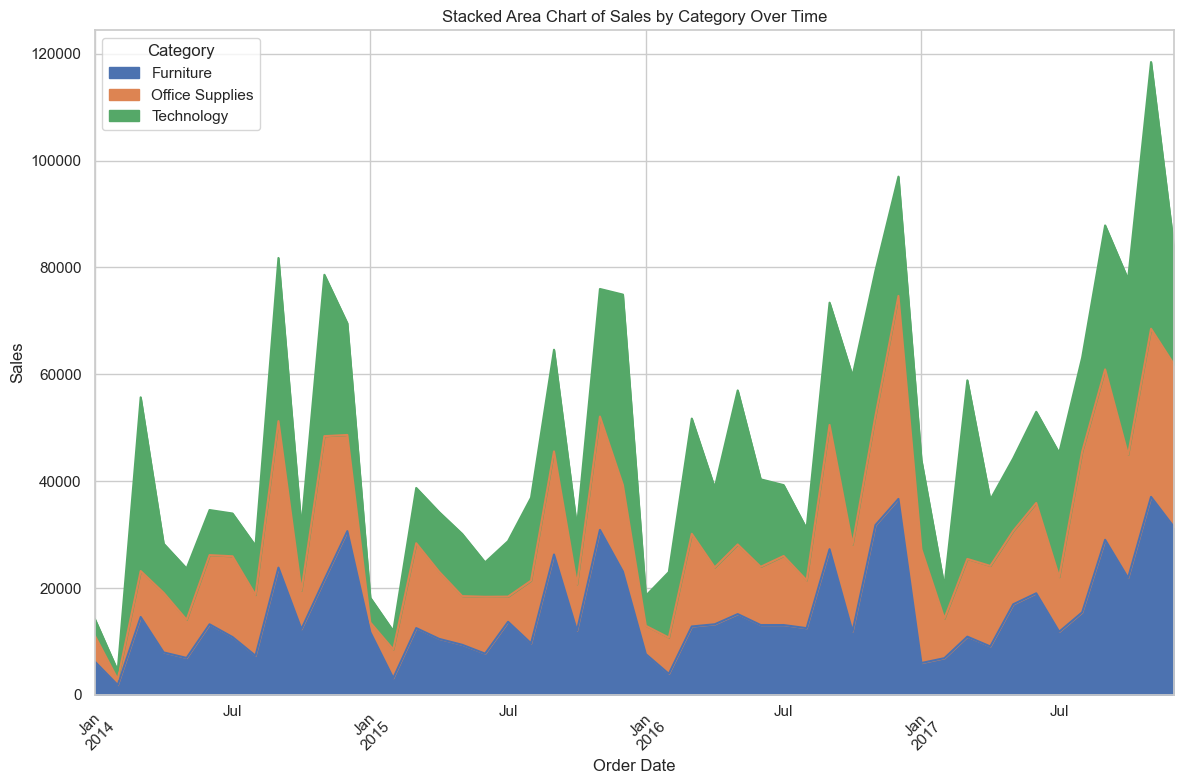

In [44]:
pivot_table = monthly_category_sales.pivot(index='Month Start', columns='Category', values='Sales')

# stacked area chart
pivot_table.plot(kind='area', stacked=True, figsize=(12, 8))

plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Stacked Area Chart of Sales by Category Over Time')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<font size = 5>Find which Item Category contribute most to Profit</font>

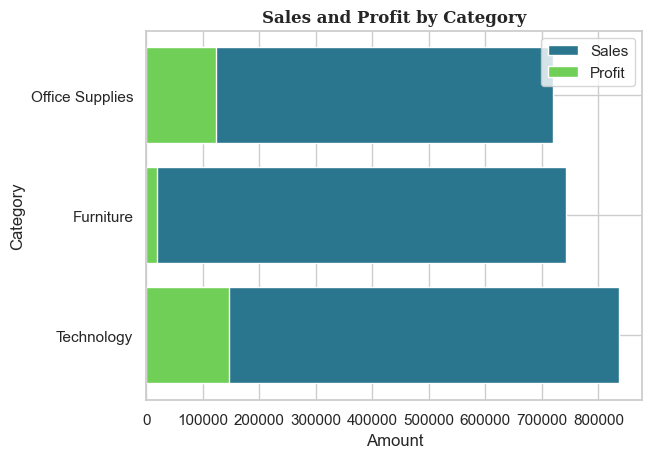

In [45]:
# Grouping by category and summing sales and profit
category_data = df.groupby('Category').agg({'Sales': 'sum', 'Profit': 'sum'}).sort_values(by='Sales', ascending=False)

# Plotting sales and profit for category
plt.barh(category_data.index, category_data['Sales'], color=cm.viridis(100), label='Sales')
plt.barh(category_data.index, category_data['Profit'], color=cm.viridis(200), label='Profit')
plt.xlabel('Amount')
plt.ylabel('Category')
plt.title('Sales and Profit by Category', fontname='serif', fontweight='bold')
plt.legend()

plt.show()

<b><u>Gathered Insights</b></u>

Technology category can be seen contributes the most towards overall profit. Furniture contributes the least towards overall profit. Office supplies contributes moderately towards overall profit.

## <font size = 5 color='yellow'><u>Data Modelling </u></font>

In [46]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

features = ['Sales', 'Quantity', 'Discount', 'Profit', 'Year', 'Month', 'Quarter']
target_category = 'Category'

X = df[features]
y_category = df[target_category]

# Encode the target variable using Label Encoding
label_encoder = LabelEncoder()
y_category_encoded = label_encoder.fit_transform(y_category)

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_category_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_cat = scaler.fit_transform(X_train_cat)
X_test_cat = scaler.transform(X_test_cat)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

xgb_model.fit(X_train_cat, y_train_cat)

y_pred_cat = xgb_model.predict(X_test_cat)

print(classification_report(y_test_cat, y_pred_cat, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test_cat, y_pred_cat):.4f}")

                 precision    recall  f1-score   support

      Furniture       0.71      0.52      0.60       413
Office Supplies       0.80      0.90      0.85      1226
     Technology       0.59      0.53      0.56       360

       accuracy                           0.75      1999
      macro avg       0.70      0.65      0.67      1999
   weighted avg       0.75      0.75      0.75      1999

Accuracy: 0.7549


## <font size = 5 color='yellow'><u> Model Validation</u></font>

K-fold Cross Validation

In [47]:
# Cross-validation
cv_scores = cross_val_score(xgb_model, X_train_cat, y_train_cat, cv=5, scoring='accuracy')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.76297686 0.75859912 0.75734834 0.76485303 0.75984991]
Mean Accuracy: 0.7607
Standard Deviation: 0.0028


<b><u>Mean: </b></u>
- Overall model's performance. A good range is between 70 to 90.

<b><u>Standard Deviation: </b></u>
- Overall model's consistency accross different k-folds (number of groups in a data sample. Standard is 5-folds). A good range is under 1, the lower the SD, the more stable the performance.

To summarize, the model has a mean accuracy of approximately 75% and standard deviation lower than 1. This means the model is fairly consistent when tested in different folds, indicating its prediction is accurate and stable. 

## <font color='Orange'><u>Sub-question 4: </u>What is the forecast for future sales? </font>

## <font size = 5 color='yellow'><u>Exploratory Data Analysis (EDA) </u></font>

<font size = 5>Find Overall Sales Trend</font>

In [48]:
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.set_index('Order Date', inplace=True)

# plt.figure(figsize=(12, 6))
# sns.lineplot(x='Order Date', y='Sales', data=daily_sales)
# plt.title('Overall Sales Trend')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.show()

In [49]:
# Resample the data on a monthly basis and sum the sales
monthly_sales = daily_sales.resample('M').sum().reset_index()

# plt.figure(figsize=(12, 6))
# sns.lineplot(x='Order Date', y='Sales', data=monthly_sales)
# plt.title('Overall Sales Trend')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.show()

C:\Users\limsi\AppData\Local\Temp\ipykernel_23844\929970169.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



<font size = 5>Find Trend, Seasonality, and Noise</font>

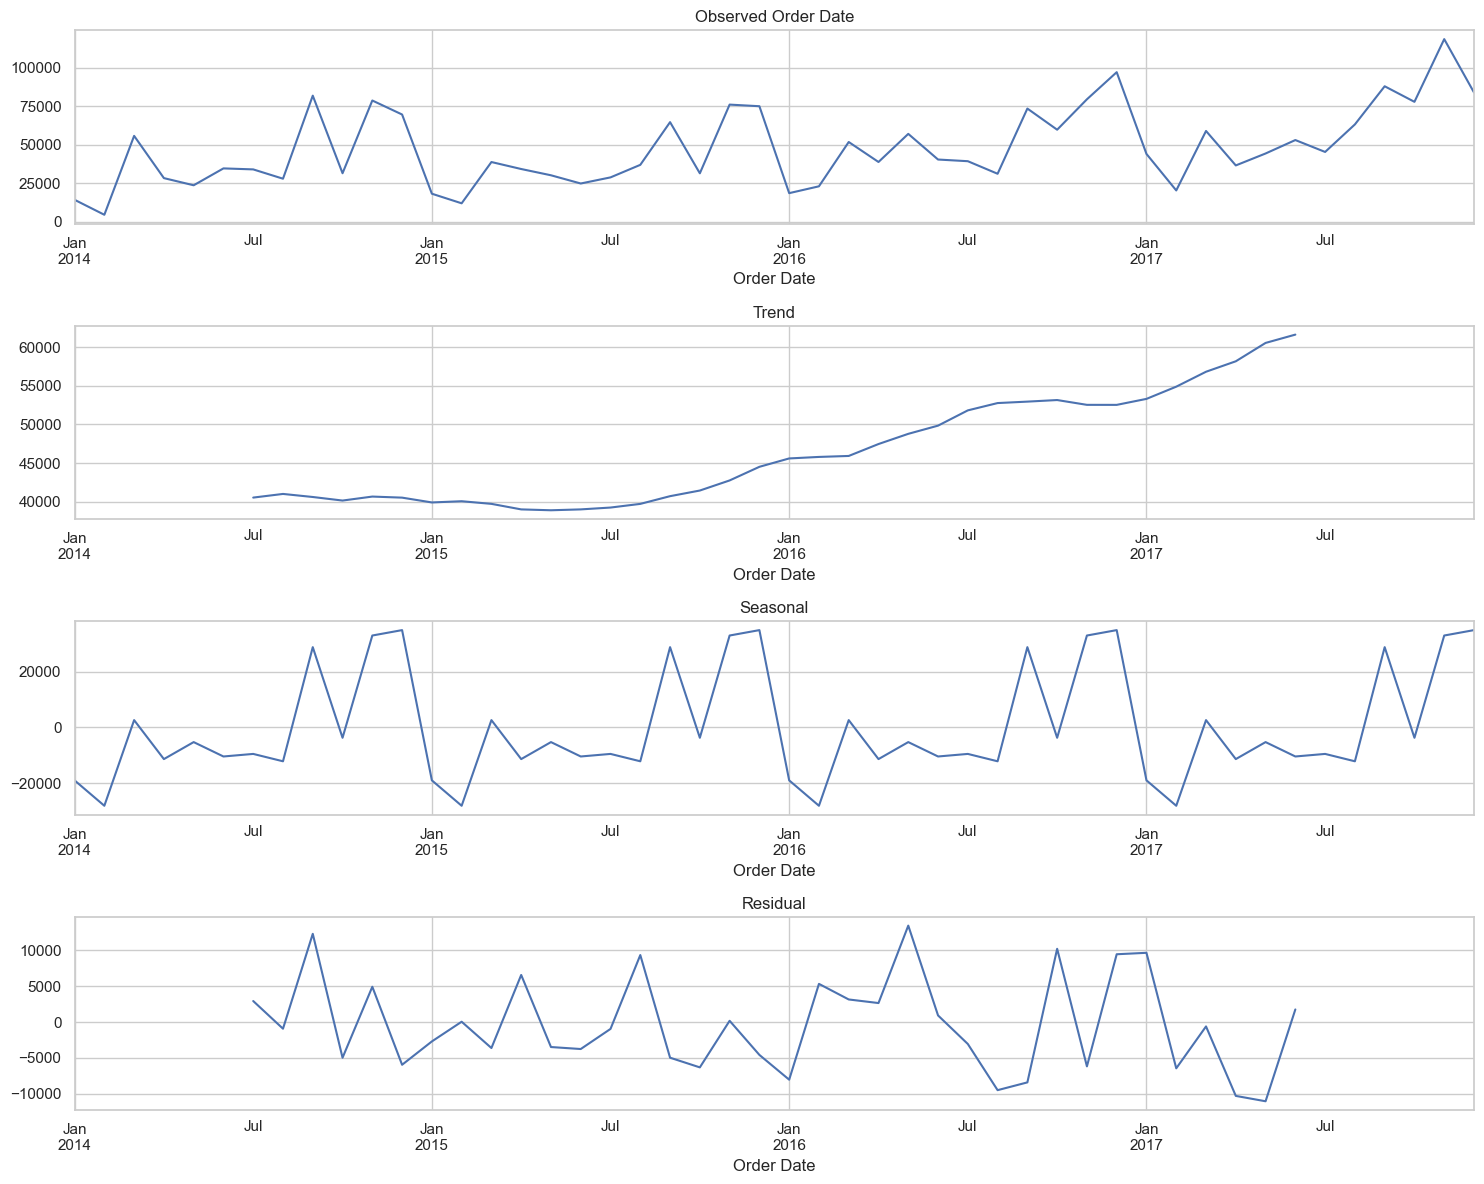

In [50]:
# pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# set order data as index to recognize data type
monthly_sales.set_index('Order Date', inplace=True)
# perform decomposition on seasons
result = seasonal_decompose(monthly_sales['Sales'], model='additive')

plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
result.observed.plot(ax=plt.gca())
plt.title('Observed Order Date')
plt.subplot(4,1,2)
result.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(4,1,3)
result.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(4,1,4)
result.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.tight_layout()
plt.show()

<font size = 5>Test for Stationary</font>

Time series is said to be stationary if statistical properties such as mean and variance remain constant over time. Most time series forecasting methods requuire the data to be stationary.

To test this, we will be using Augmented Dickey-Fuller (ADF) tes. The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value is below a certain threshold (0.05), we can reject the null hypothesis and assume the time is stationary.

In [51]:
from statsmodels.tsa.stattools import adfuller
result_adf = adfuller(monthly_sales)

test_statistic = result_adf[0]
p_value = result_adf[1]

print("Test statistic: ", test_statistic) 
print("P-value: ", p_value) 

Test statistic:  -4.493767844002665
P-value:  0.00020180198458237758


Hence, test statistic is -4.4938 and P-value is 0.0002

Stationarity is an important property in ARIMA, when a time series is not stationary, it may exhibit trends, seasonality, or other patterns that can lead to inaccurate forecasts.

## <font size = 5 color='yellow'><u>Data Modelling </u></font>

In [52]:
from statsmodels.tsa.arima.model import ARIMA # (AutoRegressive Integrated Moving Average)

p_range = range(0,3) # based on PACF
d_range = range(0,2) # no differencing
q_range = range(0,3) # based on ACF

best_aic = float('inf')
best_order = None

# loop through each 3 important variables for AMIRA
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(monthly_sales, order=(p,d,q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue

best_order, best_aic

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequenc

((0, 1, 1), 1084.6123904649342)

p = 0: No autoregressive terms

d = 1: First-order differencing

q = 1: One moving average term


The grid suggest the best ARIMA model for monthly sales data, based on the Akaike Information Criterion (AIC), is with parameters (p,d,q)=(0,1,1) and has an AIC value of approximately 1084.61.

In [53]:
# find best fit
best_model = ARIMA(monthly_sales, order = best_order)
results = best_model.fit()

results.summary()

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -540.306
Date:                Sun, 23 Jun 2024   AIC                           1084.612
Time:                        22:05:25   BIC                           1088.313
Sample:                    01-31-2014   HQIC                          1086.005
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6534      0.123     -5.315      0.000      -0.894      -0.412
sigma2      5.981e+08   2.21e-13    2.7e+21      0.000    5.98e+08    5.98e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.88   Prob(JB):                         0.93
Heteroskedasticity (H):               1.05   Skew:                            -0.00
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Use model for forecasting

<Figure size 1200x600 with 0 Axes>

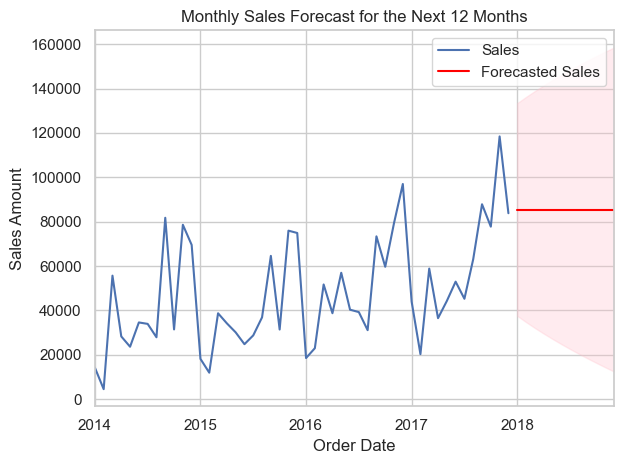

In [54]:
forecast_horizon = 12
forecast = results.get_forecast(steps=forecast_horizon)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure(figsize=(12,6))
monthly_sales.plot(label='Observed Sales', legend=True)
mean_forecast.plot(label='Forecasted Sales', legend=True, color= 'red')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:,1], color='pink', alpha=0.3)

plt.title('Monthly Sales Forecast for the Next 12 Months')
plt.ylabel('Sales Amount')
plt.xlabel('Order Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## <font size = 5 color='yellow'><u> Model Validation</u></font>

To validate an ARIMA model, we should plot out and the residuals (the difference between predicted and observed values)

The key signs of a reliable ARIMA model is whether the residuals are approximately normally distributed

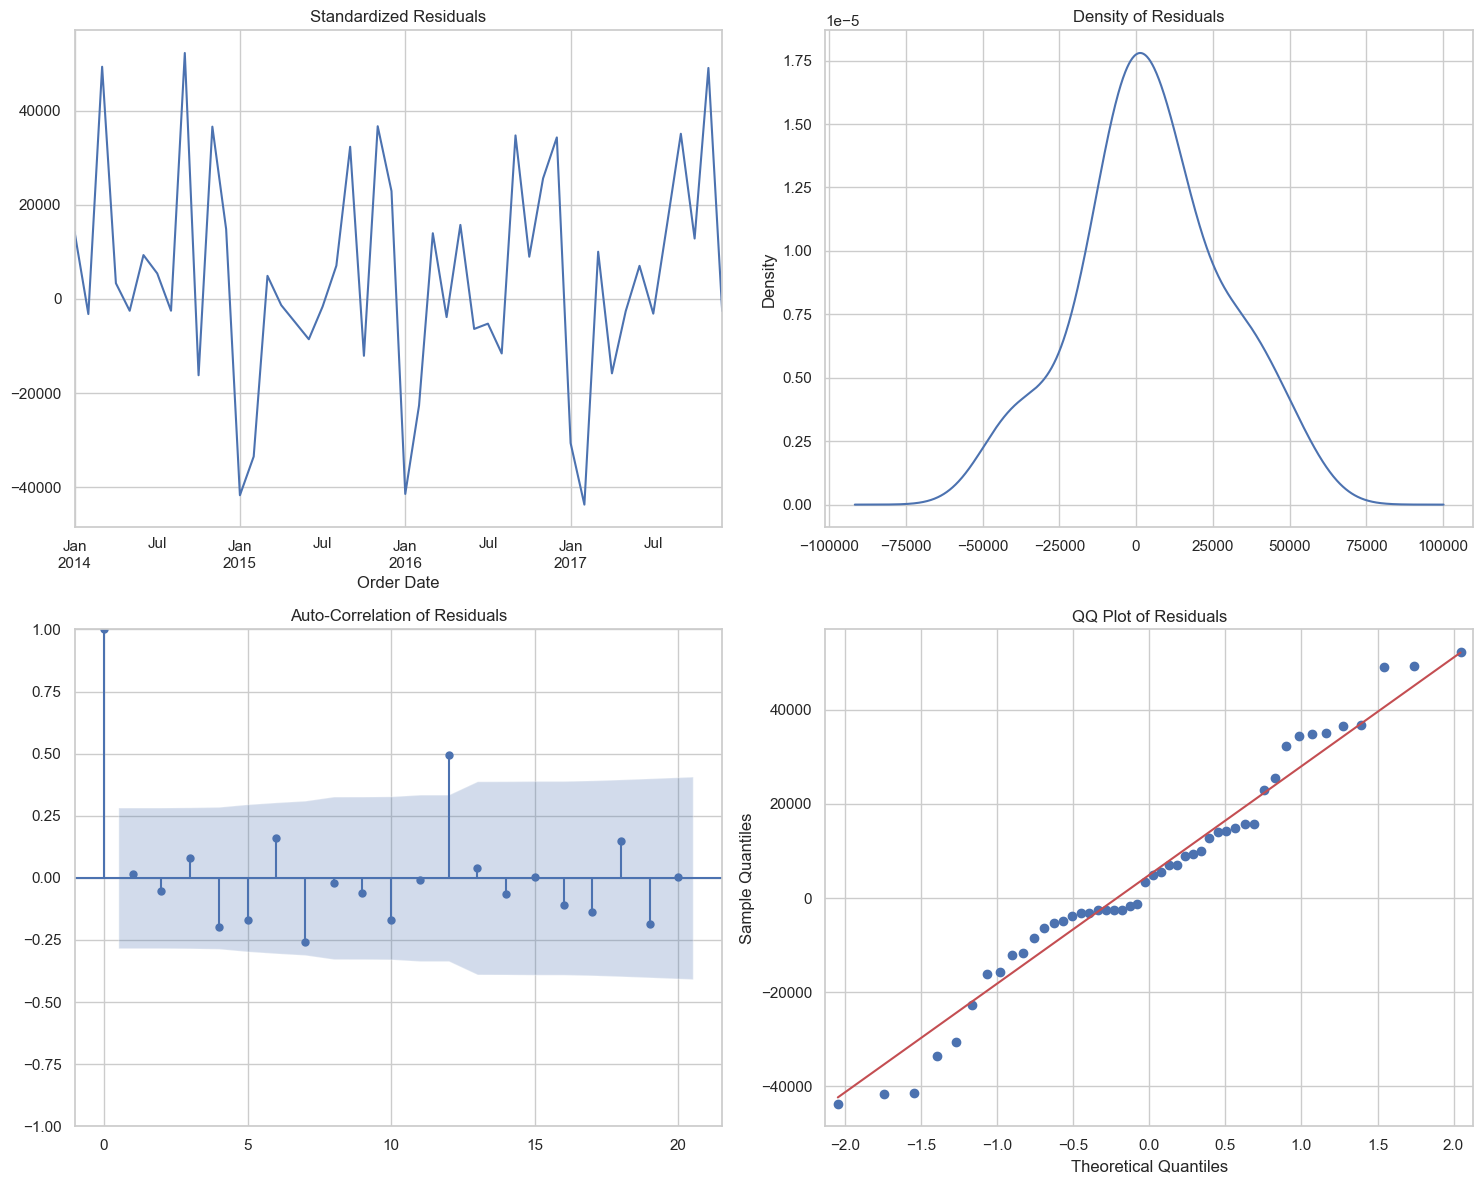

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# perform model diagnositcs
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
results.resid.plot(title='Standardized Residuals')
plt.grid(True)

plt.subplot(2,2,2)
results.resid.plot(kind='kde', title='Density of Residuals')
plt.grid(True)

plt.subplot(2,2,3)
plot_acf(results.resid, ax=plt.gca(), lags=20)
plt.title('Auto-Correlation of Residuals')


from statsmodels.graphics.gofplots import qqplot
plt.subplot(2,2,4)
qqplot(results.resid, line='s', ax=plt.gca())
plt.title('QQ Plot of Residuals')


plt.tight_layout()
plt.show()

<u><b>Standardized Residuals</u></b>

- Shows errors (residuals) of the AMIRA model over time.
- Should be randomly scattered around zero without any pattern or trends. If there is, the model failed to capture all the information in the data.

<u><b>Density Plot of Residuals</u></b>

- Shows the normal distribution of the errors.
- Should be approximately normally distributed. If there are deviations, it indicates the model's prediction is flawed because there is an outlier.

<u><b>ACF of Residuals</u></b>

- Shows the correlation of errors between periods (lagged values)
- Should show no significant autocorrelation (dependent values, which might lead the model to repeat a result) at any period, falling between the blue area

<u><b>QQ plot of Residuals</u></b>

- Shows residuals to the quantiles of standard normal distribution
- The residuals should lie close to the red line, to indicated wheter it is approximately distributed.

<u><b>Gathered Insights</u></b>

According to the graph, the residuals from the model most follows a normally distributed pattern as seen in the density and QQ plot above. 

For the graph of Standardized Residuals, there is no obvious trend or pattern, the residuals are randomly scattered around the 0 line.

Although there is an auto-correlation in the ACF of Residuals between 10 and 15 in the blue area, it is not significant enough to alter the model's prediction
